


# Transfer Learning
In the below code we will perform transfer learning using ResNet50 model on dataset CIFAR-10.
Performing transfer learning using the ResNet50 model on the CIFAR-10 dataset involves using a pre-trained ResNet50 model (pre-trained on a large dataset like ImageNet) and fine-tuning it on the CIFAR-10 dataset.


## Importing the necessary Libraries

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

Tensorflow version 2.15.0


## Parameters

In [2]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.yticks([])
  plt.xticks([])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


### Visualize Dataset

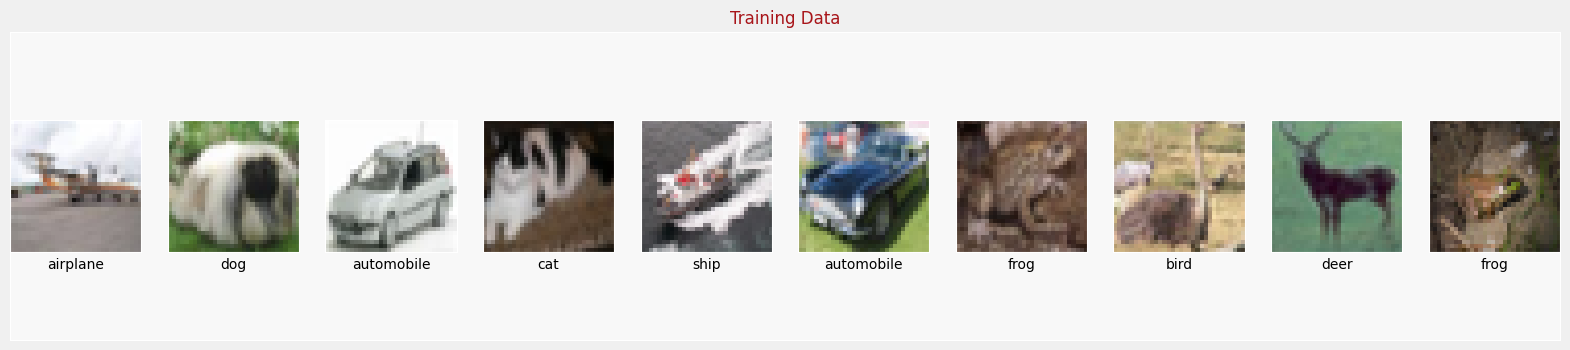

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

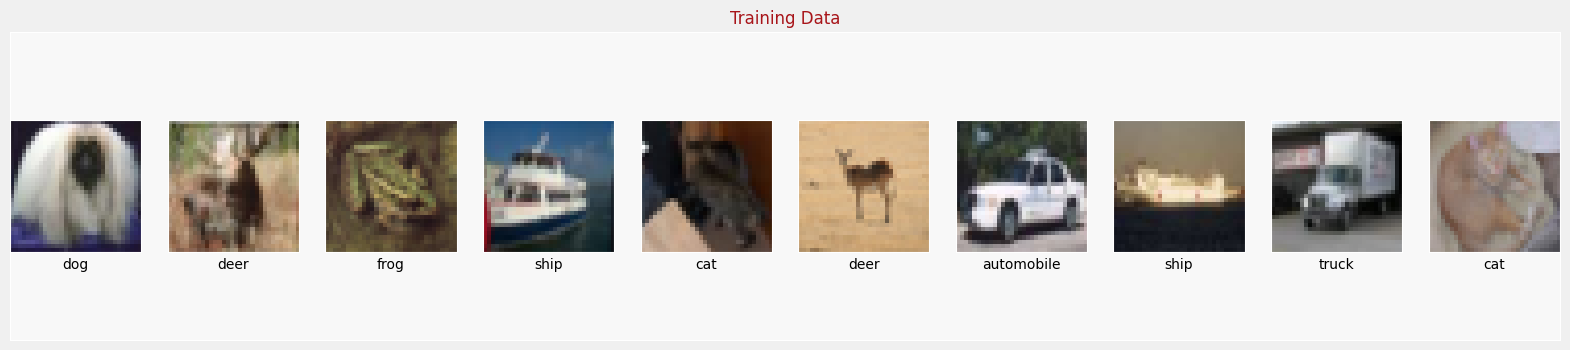

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [7]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess Dataset
Normalization on images in training and validation set.


In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Model Definition
  Performing transfer learning using **ResNet50** available in Keras.
- load the pre-trained **imagenet weights** to the model.
- All layers of RESNET50 is retained.

In [10]:
### Function to extract feature of ResNet50 pretrained on imagenet weights.Input size is 224 x 224.
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


### Defines final dense layers and subsequent softmax layer for classification.
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

### Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
### Connect the feature extraction and "classifier" layers to build the model.
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

### Define the model and compile it.
### Use Stochastic Gradient Descent as the optimizer.
### Use Sparse Categorical CrossEntropy as the loss function.

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  optimizer = SGD(learning_rate=0.01)

  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

# Define a learning rate schedule
def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create the optimizer with the learning rate schedule
optimizer = SGD(learning_rate=0.01)

# Use LearningRateScheduler during training
lr_scheduler = LearningRateScheduler(learning_rate_schedule)


model = define_compile_model()

model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

## Train the model

In [11]:
from keras.callbacks import Callback
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.98:
            print(f'\nReached 98% validation accuracy. Stopping training.')
            self.model.stop_training = True

In [13]:
history = model.fit(train_X, training_labels, epochs=6, validation_data = (valid_X, validation_labels), batch_size=64,callbacks=[lr_scheduler])

Epoch 1/6
782/782 [==============================] - 520s 638ms/step - loss: 0.3979 - accuracy: 0.8691 - val_loss: 0.2186 - val_accuracy: 0.9249 - lr: 0.0100
Epoch 2/6
782/782 [==============================] - 513s 656ms/step - loss: 0.1052 - accuracy: 0.9661 - val_loss: 0.1612 - val_accuracy: 0.9462 - lr: 0.0100
Epoch 3/6
782/782 [==============================] - 513s 656ms/step - loss: 0.0333 - accuracy: 0.9908 - val_loss: 0.1633 - val_accuracy: 0.9491 - lr: 0.0100
Epoch 4/6
782/782 [==============================] - 496s 634ms/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 0.1727 - val_accuracy: 0.9515 - lr: 0.0100
Epoch 5/6
782/782 [==============================] - 512s 655ms/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 0.1698 - val_accuracy: 0.9531 - lr: 0.0100
Epoch 6/6
782/782 [==============================] - 496s 635ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.1792 - val_accuracy: 0.9533 - lr: 0.0100


## Evaluate the Model

In [16]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 25s 158ms/step - loss: 0.1792 - accuracy: 0.9533


##Plot Loss and Accuracy Curves

Plot the loss in blue and validation loss in green.

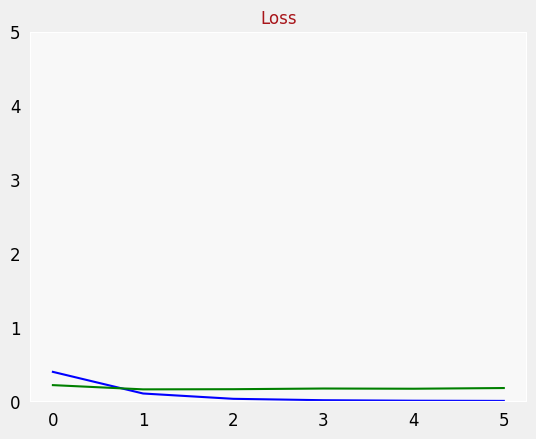

In [17]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

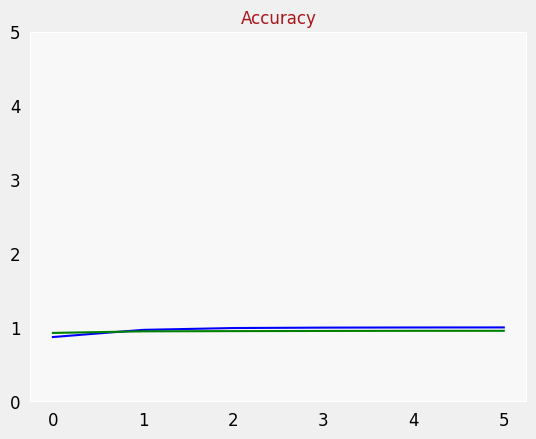

In [18]:
plot_metrics("accuracy", "Accuracy")